# 3.4 Classifying movie reviews: a binary classification example
Two-class classification, or binary classification, may be the most widely applied kind of machine-learning problem. This example will introduce how to classify movie reviews as positive or negative, based on the text content of the reviews.

In [2]:
from tensorflow import keras

## 3.4.1 The IMDB dataset

IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.

Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

In [3]:
from keras.datasets import imdb

In [4]:
(train_data, train_labels), (test_data, test_labels) = \
imdb.load_data(num_words=10000)

17464789/17464789 [==============================] - 0s 0us/step


The argument `num_words=10000` means you’ll only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded. This allows you to work with vector data of manageable size.

The variables `train_data` and `test_data` are lists of reviews; each review is a list of word indices (encoding a sequence of words). `train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive.

In [5]:
print("length of sequence:", len(train_data[0]))
print(train_data[0])
print("label:", train_labels[0])

length of sequence: 218
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
label: 1


Because you’re restricting yourself to the top 10,000 most frequent words, no word index will exceed 10,000.

In [6]:
max([max(sequence) for sequence in train_data])

9999

## 3.4.2 Preparing the data
You can’t feed lists of integers into a neural network. You have to turn your lists into tensors. There are two ways to do that:
- Pad your lists so that they all have the same length, turn them into an integer tensor of shape (samples, word_indices), and then use as the first layer in your network a layer capable of handling such integer tensors (the Embedding layer).
- One-hot encode your lists to turn them into vectors of 0s and 1s. This would mean, for instance, turning the sequence [3, 5] into a 10,000-dimensional vector that would be all 0s except for indices 3 and 5, which would be 1s. Then you could use as the first layer in your network a Dense layer, capable of handling floating-point vector data.

Let’s go with the latter solution to vectorize the data, which you’ll do manually for maximum clarity.

### *Encoding the integer sequences into a binary matrix*

In [7]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [8]:
print(len(x_train[0]))
x_train[0]

10000


array([0., 1., 1., ..., 0., 0., 0.])

In [9]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

##  3.4.3 Building your network
The input data is vectors, and the labels are scalars (1s and 0s): this is the easiest setup you’ll ever encounter. A type of network that performs well on such a problem is a simple stack of fully connected (Dense) layers with relu activations: `Dense(16, activation='relu')`.

The argument being passed to each Dense layer (16) is the number of hidden units of the layer. A hidden unit is a dimension in the representation space of the layer. You may remember from chapter 2 that each such Dense layer with a relu activation implements the following chain of tensor operations:

`output = relu(dot(W, input) + b)`

Having 16 hidden units means the weight matrix W will have shape `(input_dimension, 16)`: the dot product with W will project the input data onto a 16-dimensional representation space (and then you’ll add the bias vector b and apply the relu operation). 

You can intuitively understand the dimensionality of your representation space as “how much freedom you’re allowing the network to have when learning internal representations.” Having more hidden units (a higher-dimensional representation space) allows your network to learn more-complex representations, but it makes the network more computationally expensive and may lead to learning unwanted patterns (patterns that will improve performance on the training data but not on the test data).

There are two key architecture decisions to be made about such a stack of Dense layers:
- How many layers to use
- How many hidden units to choose for each layer

In chapter 4, you’ll learn formal principles to guide you in making these choices. For the time being, you’ll have to trust me with the following architecture choice:
- Two intermediate layers with 16 hidden units each
- A third layer that will output the scalar prediction regarding the sentiment of the current review

The intermediate layers will use relu as their activation function, and the final layer will use a sigmoid activation so as to output a probability (a score between 0 and 1, indicating how likely the sample is to have the target “1”: how likely the review is to be positive).

### *The model definition*

In [10]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Finally, you need to choose a loss function and an optimizer. Because you’re facing a binary classification problem and the output of your network is a probability (you end your network with a single-unit layer with a sigmoid activation), it’s best to use the `binary_crossentropy loss`. It isn’t the only viable choice: you could use, for instance, `mean_squared_error`. But crossentropy is usually the best choice when you’re dealing with models that output probabilities. *Crossentropy* is a quantity that measures the distance between probability distributions or, in this case, between the ground-truth distribution and your predictions. 

Here’s the step where you configure the model with the `rmsprop` optimizer and the `binary_crossentropy` loss function. Note that you’ll also monitor accuracy during training.

### *Compiling the model*

In [11]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', \
              metrics=['accuracy'])

You’re passing your optimizer, loss function, and metrics as strings, which is possible because `rmsprop`, `binary_crossentropy`, and `accuracy` are packaged as part of Keras.

### *Configuring the optimizer*
Sometimes you may want to configure the parameters of your optimizer, which can be done by passing an optimizer class instance as the `optimizer` argument:

In [13]:
from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001), \
              loss='binary_crossentropy', metrics=['accuracy'])

Additionally, you may also want to pass a custom loss function or metric function, which can be done by passing function objects as the `loss` and/or `metrics` arguments:
### *Using custom losses and metrics*

In [16]:
from keras import losses
from keras import metrics
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),\
              loss=losses.binary_crossentropy,\
              metrics=[metrics.binary_accuracy])

## 3.4.4 Validate your approach

### *Setting aside a validation set*
In order to monitor during training the accuracy of the model on data it has never seen before, you’ll create a validation set by setting apart 10,000 samples from the original training data.

In [17]:
# review train/test
print(len(x_train))
print(len(x_test))

25000
25000


In [18]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [19]:
print("training:", len(partial_x_train))
print("validation:", len(x_val))
print("test:", len(x_test))

training: 15000
validation: 10000
test: 25000


### *Training your model*
You’ll now train the model for 20 epochs (20 iterations over all samples in the`x_train` and `y_train` tensors), in mini-batches of 512 samples. At the same time, you’ll monitor loss and accuracy on the 10,000 samples that you set apart. You do so by passing the validation data as the `validation_data` argument.

In [20]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(partial_x_train, partial_y_train, epochs=20,\
                    batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 2s 54ms/step - loss: 0.5094 - acc: 0.7835 - val_loss: 0.4077 - val_acc: 0.8419
Epoch 2/20
30/30 [==============================] - 1s 21ms/step - loss: 0.3143 - acc: 0.8934 - val_loss: 0.3084 - val_acc: 0.8860
Epoch 3/20
30/30 [==============================] - 1s 27ms/step - loss: 0.2356 - acc: 0.9206 - val_loss: 0.2859 - val_acc: 0.8852
Epoch 4/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1899 - acc: 0.9364 - val_loss: 0.2899 - val_acc: 0.8815
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1610 - acc: 0.9463 - val_loss: 0.2773 - val_acc: 0.8878
Epoch 6/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1353 - acc: 0.9577 - val_loss: 0.2960 - val_acc: 0.8877
Epoch 7/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1166 - acc: 0.9643 - val_loss: 0.2973 - val_acc: 0.8841
Epoch 8/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0988 - a

On CPU, this will take less than 2 seconds per epoch—training is over in 20 seconds. At the end of every epoch, there is a slight pause as the model computes its loss and accuracy on the 10,000 samples of the validation data.

Note that the call to `model.fit()` returns a `History` object. This object has a member `history`, which is a dictionary containing data about everything that happened during training. Let’s look at it:

In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

The dictionary contains four entries: one per metric that was being monitored during training and during validation. Let's use Matplotlib to plot the training and validation loss side by side (see figure 1), as well as the training and validation accuracy (see figure 2). Note that your own results may vary slightly due to a different random initialization of your network.

In [22]:
# review the entries in history
print(len(history_dict['loss']))
print(history_dict['loss'])

print(len(history_dict['acc']))
print(history_dict['acc'])

print(len(history_dict['val_loss']))
print(history_dict['val_loss'])

print(len(history_dict['val_acc']))
print(history_dict['val_acc'])

20
[0.5094375610351562, 0.3142523467540741, 0.23556166887283325, 0.18990358710289001, 0.16096755862236023, 0.13527916371822357, 0.11662101745605469, 0.09883010387420654, 0.08958550542593002, 0.0715596079826355, 0.06363701820373535, 0.054364245384931564, 0.045131031423807144, 0.036826904863119125, 0.03469710424542427, 0.02588791772723198, 0.023875461891293526, 0.01917784847319126, 0.01614539325237274, 0.018344178795814514]
20
[0.783466637134552, 0.8934000134468079, 0.9205999970436096, 0.9363999962806702, 0.9463333487510681, 0.9576666951179504, 0.9643333554267883, 0.9721999764442444, 0.9729333519935608, 0.980733335018158, 0.9824666380882263, 0.986466646194458, 0.990066647529602, 0.9926000237464905, 0.9920666813850403, 0.9959999918937683, 0.9959333539009094, 0.9981333613395691, 0.998199999332428, 0.996399998664856]
20
[0.40766656398773193, 0.30838266015052795, 0.2858664095401764, 0.2898884415626526, 0.277255654335022, 0.29602840542793274, 0.2972869575023651, 0.3160898685455322, 0.33030837

### *Plotting the training and validation loss*

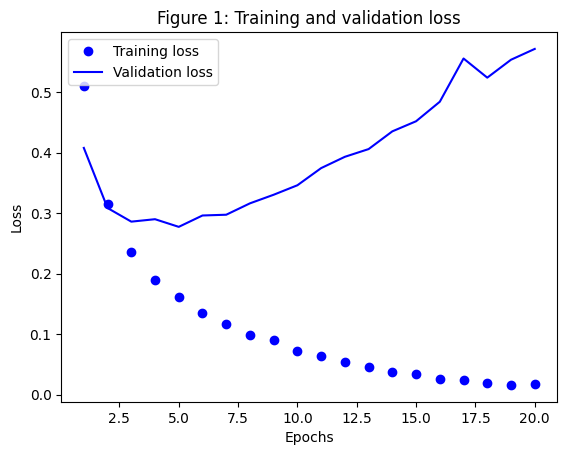

In [23]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(history_dict['acc']) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss_values, 'bo', label='Training loss')
# "b" is for "solid blue line"
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Figure 1: Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### *Plotting the training and validation accuracy*

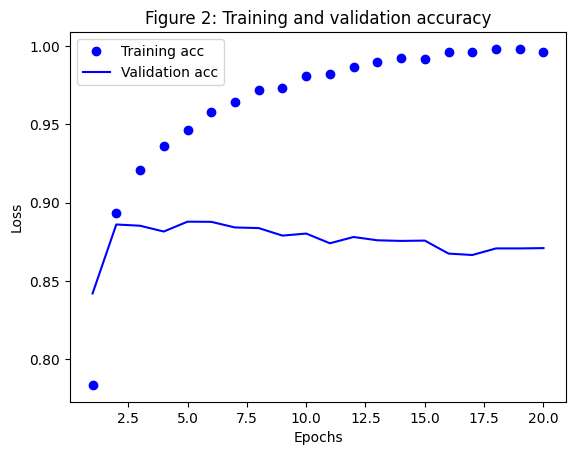

In [24]:
# clear the figure
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Figure 2: Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

As you can see, the training loss decreases with every epoch, and the training accuracy increases with every epoch. That’s what you would expect when running gradient descent optimization—the quantity you’re trying to minimize should be less with every iteration. 

But that isn’t the case for the validation loss and accuracy: they seem to peak at the fourth epoch. This is an example of what we warned against earlier: a model that performs better on the training data isn’t necessarily a model that will do better on data it has never seen before. In precise terms, what you’re seeing is overfitting: after the second epoch, you’re overoptimizing on the training data, and you end up learning representations that are specific to the training data and don’t generalize to data outside of the training set.

In this case, to prevent overfitting, you could stop training after three epochs. In general, you can use a range of techniques to mitigate overfitting, which we’ll cover in chapter 4.

Let’s train a new network from scratch for four epochs and then evaluate it on the test data.

### *Retraining a model from scratch*

In [25]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy',\
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 1s 17ms/step - loss: 0.4735 - accuracy: 0.8165
Epoch 2/4
49/49 [==============================] - 1s 15ms/step - loss: 0.2802 - accuracy: 0.9015
Epoch 3/4
49/49 [==============================] - 1s 15ms/step - loss: 0.2188 - accuracy: 0.9194
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.2894 - accuracy: 0.8851


In [26]:
results

[0.2894481122493744, 0.8850799798965454]

This fairly naive approach achieves an accuracy of 88%. With state-of-the-art approaches, you should be able to get close to 95%.

## 3.4.5 Using a trained network to generate predictions on new data
After having trained a network, you’ll want to use it in a practical setting. You can generate the likelihood of reviews being positive by using the `predict` method:

In [27]:
model.predict(x_test)

782/782 [==============================] - 1s 2ms/step


array([[0.2840853 ],
       [0.99977314],
       [0.9295521 ],
       ...,
       [0.11097129],
       [0.11324021],
       [0.66110903]], dtype=float32)

As you can see, the network is confident for some samples (0.99 or more, or 0.01 or less) but less confident for others (0.6, 0.4).

# 3.4.6 Further experiments
The following experiments will help convince you that the architecture choices you’ve made are all fairly reasonable, although there’s still room for improvement:
- You used two hidden layers. Try using one or three hidden layers, and see how doing so affects validation and test accuracy.
- Try using layers with more hidden units or fewer hidden units: 32 units, 64 units, and so on.
- Try using the `mse` loss function instead of `binary_crossentropy`.
- Try using the `tanh` activation (an activation that was popular in the early days of neural networks) instead of `relu`.

# 3.4.7 Wrapping up
Here’s what you should take away from this example:
- You usually need to do quite a bit of preprocessing on your raw data in order to be able to feed it—as tensors—into a neural network. Sequences of words can be encoded as binary vectors, but there are other encoding options, too.
- Stacks of `Dense` layers with `relu` activations can solve a wide range of problems (including sentiment classification), and you’ll likely use them frequently.
- In a binary classification problem (two output classes), your network should end with a `Dense` layer with one unit and a `sigmoid` activation: the output of your network should be a scalar between 0 and 1, encoding a probability.
- With such a scalar sigmoid output on a binary classification problem, the loss function you should use is `binary_crossentropy`.
- The `rmsprop` optimizer is generally a good enough choice, whatever your problem. That’s one less thing for you to worry about.
- As they get better on their training data, neural networks eventually start overfitting and end up obtaining increasingly worse results on data they’ve never seen before. Be sure to always monitor performance on data that is outside of the training set. 